# 我们利用最简单的回归模型看一下上证综指的婴儿底到底在哪里。

In [31]:
import pandas.io.data as web
import datetime
import pandas as pd
from scipy.stats import norm


import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# Refer to: 
# http://pandas.pydata.org/pandas-docs/stable/remote_data.html

start = datetime.datetime(1992, 8, 12)
end = datetime.datetime(2016, 5, 20)

# If you want to run this notebook at your local instance, uncomment those lines of code and fetch the latest index from Yahoo again.
'''
shanghai = web.DataReader("000001.SS", 'yahoo', start, end)
shanghai.head()
shanghai.to_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
'''


'\nshanghai = web.DataReader("000001.SS", \'yahoo\', start, end)\nshanghai.head()\nshanghai.to_csv(\'C:\\qduan\\Stanmo\\stock_minima\\shanghai_index_1992_2016.csv\')\n'

In [33]:
shanghai = pd.DataFrame.from_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
print(shanghai.count())
shanghai.head()

Open         6063
High         6063
Low          6063
Close        6063
Volume       6063
Adj Close    6063
dtype: int64


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21
1992-08-13,850.94,850.94,850.94,850.94,0,850.94
1992-08-14,858.38,858.38,858.38,858.38,0,858.38
1992-08-17,939.46,939.46,939.46,939.46,0,939.46
1992-08-18,933.44,933.44,933.44,933.44,0,933.44


In [34]:
sh = shanghai.copy()
sh['date1'] = shanghai.index
#http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
sh['days'] = sh['date1'].apply(lambda x:  (x-start).days)
sh.head()

,Open,High,Low,Close,Volume,Adj Close,date1,days
Date,,,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21,1992-08-12,0
1992-08-13,850.94,850.94,850.94,850.94,0,850.94,1992-08-13,1
1992-08-14,858.38,858.38,858.38,858.38,0,858.38,1992-08-14,2
1992-08-17,939.46,939.46,939.46,939.46,0,939.46,1992-08-17,5
1992-08-18,933.44,933.44,933.44,933.44,0,933.44,1992-08-18,6


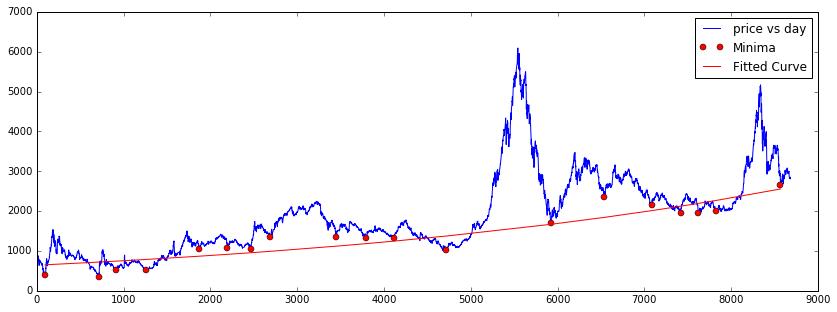

In [35]:
import numpy as np 
from scipy.optimize import curve_fit

xx = sh['days'].values
yy = sh['Close'].values

# http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html
from scipy.signal import argrelextrema
local_min_ix =  argrelextrema(yy, np.less,   order=100)

''' 
order = 50
func = a * np.exp(b * x)
p0=[  7.47923284e+02,   1.54713441e-04,   2.25849076e+02] 

order = 100
func = a * np.exp(b * x)
p0=[  6.42161050e+02   1.61137085e-04   2.25849076e+02]

'''

x_minima=xx[local_min_ix]
y_minima=yy[local_min_ix]

def exp_func(x, a, b, c):
    return a * np.exp(b * x)
popt_minima, pcov_minima = curve_fit(exp_func, x_minima, y_minima, p0=[ 5.69396441e+02,   1.93941219e-04,   2.25849076e+02])
#print(popt_minima)



plt.figure(figsize=(14,5))
plt.plot(xx, yy, 'b-', label="price vs day") 
plt.plot(x_minima, y_minima, 'ro', label="Minima") 
plt.plot(x_minima, exp_func(x_minima, *popt_minima), 'r-', label="Fitted Curve")


plt.legend()
plt.show()



In [36]:
x_minima

array([  97,  716,  909, 1258, 1868, 2196, 2470, 2693, 3450, 3796, 4115,
       4716, 5928, 6536, 7085, 7418, 7624, 7831, 8569], dtype=int64)

In [37]:
'''from datetime import datetime, timedelta

def add_start_date(a):
    days_add = int(a[0]) 
    print(start)
    print(days_add)
    # return datetime(1992, 8, 12)  +  timedelta(days=1) 
    return np.datetime64('1992-08-12') + np.timedelta64(days_add,'D') 

x_minima_date = np.apply_along_axis(add_start_date, 0, x_minima)
x_minima_date
'''

"from datetime import datetime, timedelta\n\ndef add_start_date(a):\n    days_add = int(a[0]) \n    print(start)\n    print(days_add)\n    # return datetime(1992, 8, 12)  +  timedelta(days=1) \n    return np.datetime64('1992-08-12') + np.timedelta64(days_add,'D') \n\nx_minima_date = np.apply_along_axis(add_start_date, 0, x_minima)\nx_minima_date\n"

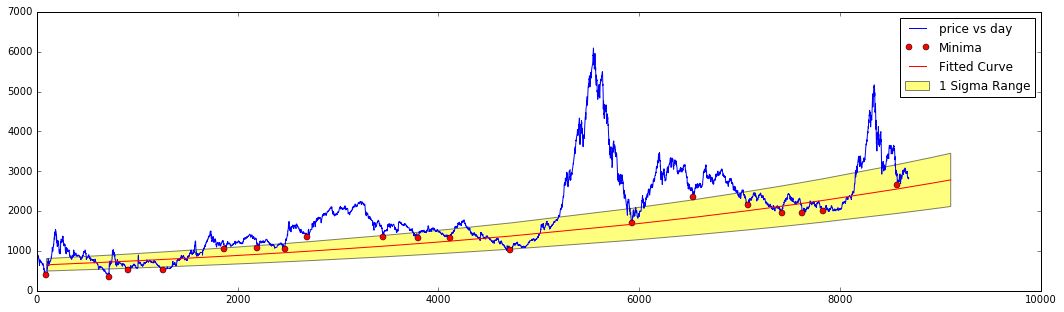

In [40]:
x_extended=np.append(  xx[local_min_ix], [8900, 9000, 9100] )

# Generate some data for this demonstration.
data =( exp_func(x_minima, *popt_minima)-y_minima ) / exp_func(x_minima, *popt_minima)
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# the 1 sigma upper and lower analytic population bounds
lower_bound = exp_func(x_extended, *popt_minima)*(1-std)
upper_bound = exp_func(x_extended, *popt_minima)*(1+std)


#print(data[1:len(data)]) 
#len(data)

plt.figure(figsize=(18,5))
plt.plot(xx, yy, 'b-', label="price vs day") 
plt.plot(x_minima, y_minima, 'ro', label="Minima") 
plt.plot(x_extended, exp_func(x_extended, *popt_minima), 'r-', label="Fitted Curve")
plt.fill_between(x_extended, lower_bound, upper_bound, facecolor='yellow', alpha=0.5,
                label='1 Sigma Range')



plt.legend()
plt.show()


 Now we check a few statistics. According to 

In [41]:
print(exp_func(x_extended, *popt_minima))

[  652.27707024   720.69302351   743.45834529   786.46607064   867.69754532
   914.79149755   956.08586801   991.0661661   1119.6395393   1183.83625063
  1246.27980186  1373.01128148  1669.13326823  1840.9391305   2011.21717437
  2122.08426067  2193.70739527  2268.1133526   2554.52815785  2694.47642153
  2738.24612827  2782.72684039]


In [42]:
print(np.diff(x_minima))
print(np.amin(np.diff(x_minima)))

[ 619  193  349  610  328  274  223  757  346  319  601 1212  608  549  333
  206  207  738]
193


In [48]:
from scipy.stats import norm

In [54]:
norm(mu, std).cdf(mu-std)


0.15865525393145707

In [44]:
## Then we know the expected low end of shanghai index as: 
print(exp_func(8700, *popt_minima))
#xx[1:20]


2609.02474536


[Some answers from web](http://zhidao.baidu.com/question/347142653.html)
2001年至2010年十年间年平均交易日是240.8天。2010年的交易日是242天。不过由于周末与年的频率不一致，所以每年可能会由1天左右的上下浮动，所以比较准确的说法是(241±1)天。


In [45]:
print(popt_minima[1])
print(np.exp(240.8*popt_minima[1]))

0.000161137085168
1.03956443207


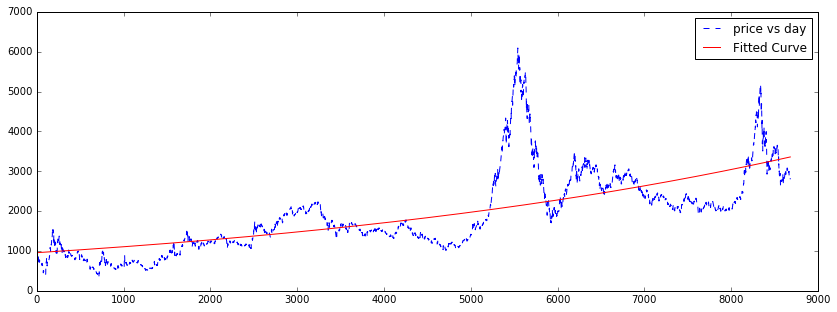

In [46]:
'''import random
rows = random.sample(sh.index, 30)
rows.sort()
sh_600 = sh.ix[rows]
'''

# Now use all data
#sh_600 =  

x_all = sh['days'].values
y_all = sh['Close'].values

# print(x1.shape)

def exp_func(x, a, b, c):
    return a * np.exp(b * x)  
# p0=[100, 0.001, 900])
# ([  5.69396441e+02,   1.93941219e-04,   2.25849076e+02])
popt_all, pcov_all = curve_fit(exp_func, x_all, y_all, p0=[ 2.28786762e+04,   1.64695236e-05,  -2.23512090e+04])
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b--', label="price vs day") 
plt.plot(x_all, exp_func(x_all, *popt_all), 'r-', label="Fitted Curve")
plt.legend()
plt.show()


In [47]:

x1=xx[local_min_ix]
y1=yy[local_min_ix]

# Generate some data for this demonstration.
data =( exp_func(x1, *popt1)-y1 ) / exp_func(x1, *popt1)
# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# the 1 sigma upper and lower analytic population bounds
lower_bound = exp_func(x1, *popt1)*(1-std)
upper_bound = exp_func(x1, *popt1)*(1+std)



print(data[1:len(data)]) 
len(data)

# Plot the histogram.
plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

NameError: name 'popt1' is not defined